# Imports

In [37]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Consts

In [38]:
g_const = 9.81
R = 1.0
alpha0 = 0.5
alpha1 = 1000.0
lam = 1.0

# Functions

In [39]:
def alpha(t):
    return alpha0 + alpha1 * math.exp(-lam * t)

def f_theta(t, theta, v):
    return v

def g_v(t, theta, v):
    return -(g_const/R) * math.sin(theta) - alpha(t) * v

def rk2_step(theta, v, dt, t):
    k1x = f_theta(t, theta, v)
    k1v = g_v(t, theta, v)

    k2x = f_theta(t + dt, theta + dt * k1x, v + dt * k1v)
    k2v = g_v(t + dt, theta + dt * k1x, v + dt * k1v)

    theta_next = theta + dt * 0.5 * (k1x + k2x)
    v_next = v + dt * 0.5 * (k1v + k2v)
    return theta_next, v_next

def trapezoid_step(theta, v, dt, t, tol_newton=1e-10, max_iter=50):
    theta_np1 = theta
    v_np1 = v
    t_np1 = t + dt

    for k in range(max_iter):
        f_n = f_theta(t, theta, v)
        g_n = g_v(t, theta, v)

        f_np1 = f_theta(t_np1, theta_np1, v_np1)
        g_np1 = g_v(t_np1, theta_np1, v_np1)

        F = theta_np1 - theta - 0.5 * dt * (f_n + f_np1)
        G = v_np1 - v - 0.5 * dt * (g_n + g_np1)

        a11 = 1.0
        a12 = -0.5 * dt
        a21 = 0.5 * dt * (g_const / R) * math.cos(theta_np1)
        a22 = 1.0 + 0.5 * dt * alpha(t_np1)

        det = a11 * a22 - a12 * a21
        if det == 0.0:
            raise ZeroDivisionError("Zero determinant in Newton solver")

        dx = (-F * a22 - (-G) * a12) / det
        dv = (a11 * (-G) - a21 * (-F)) / det

        theta_np1 += dx
        v_np1 += dv

        if abs(dx) < tol_newton and abs(dv) < tol_newton:
            break

    return theta_np1, v_np1

def integrate_adaptive(method, t_max, tol, theta0, v0,
                       dt0=0.01, S=0.75, p=2):
    if method == 'rk2':
        step_fun = rk2_step
    elif method == 'trap':
        step_fun = trapezoid_step
    else:
        raise ValueError("Unknown method")

    t = 0.0
    dt = dt0
    theta = theta0
    v = v0

    ts = [t]
    thetas = [theta]
    vs = [v]
    dts = [dt]
    accepted_steps = 0

    while t < t_max:
        if t + 2 * dt > t_max:
            dt = (t_max - t) / 2.0
            if dt <= 0.0:
                break

        # dwa małe kroki
        th1, v1 = step_fun(theta, v, dt, t)
        th2, v2 = step_fun(th1, v1, dt, t + dt)

        # jeden duży krok
        th_big, v_big = step_fun(theta, v, 2.0 * dt, t)

        factor = 2 ** p - 1
        Ex = (th2 - th_big) / factor
        Ev = (v2 - v_big) / factor
        err = max(abs(Ex), abs(Ev))

        if err < tol or err == 0.0:
            t += 2.0 * dt
            theta, v = th2, v2
            ts.append(t)
            thetas.append(theta)
            vs.append(v)
            dts.append(dt)
            accepted_steps += 1

        if err == 0.0:
            dt_new = dt * 2.0
        else:
            dt_new = dt * (S * tol / err) ** (1.0 / (p + 1))

        dt = dt_new

    return (np.array(ts),
            np.array(thetas),
            np.array(vs),
            np.array(dts),
            accepted_steps)

theta0 = math.radians(179.0)
v0 = 0.0

tmax_list = [10.0, 30.0, 150.0]
tols = [1e-2, 1e-5]
methods = ['rk2', 'trap']

results = {}  # klucz: (method, tol, tmax)

for method in methods:
    for tol in tols:
        for tmax in tmax_list:
            key = (method, tol, tmax)
            results[key] = integrate_adaptive(method, tmax, tol,
                                              theta0, v0)
            
for tmax in tmax_list:
    print(f"t_max = {tmax}")
    for method in methods:
        for tol in tols:
            ts, thetas, vs, dts, nsteps = results[(method, tol, tmax)]
            name = "RK2 " if method == "rk2" else "Trapezy "
            print(f"  {name}tol={tol:1.0e}: liczba kroków = {nsteps}")
    print()
    


t_max = 10.0
  RK2 tol=1e-02: liczba kroków = 279
  RK2 tol=1e-05: liczba kroków = 522
  Trapezy tol=1e-02: liczba kroków = 31
  Trapezy tol=1e-05: liczba kroków = 221

t_max = 30.0
  RK2 tol=1e-02: liczba kroków = 339
  RK2 tol=1e-05: liczba kroków = 1034
  Trapezy tol=1e-02: liczba kroków = 72
  Trapezy tol=1e-05: liczba kroków = 629

t_max = 150.0
  RK2 tol=1e-02: liczba kroków = 537
  RK2 tol=1e-05: liczba kroków = 1304
  Trapezy tol=1e-02: liczba kroków = 88
  Trapezy tol=1e-05: liczba kroków = 731



# Plots

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import math

# WAŻNE: Wymaga, aby funkcje globalne (alpha) i słownik wyników (results)
# były zdefiniowane w bieżącym kontekście. Zakładam, że są one dostępne.
# Dla celów wykonania, konieczne jest ponowne wklejenie całego kodu kontekstowego.
# Poniżej znajduje się tylko poprawiona funkcja.

def make_figure(tmax, results, alpha):
    fig, axes = plt.subplots(5, 2, figsize=(12, 20)) # Zwiększenie rozmiaru figury

    tol_list = [1e-2, 1e-5]
    tol_labels = {1e-2: "tol = 1.e-2", 1e-5: "tol = 1.e-5"}

    # 1. Wiersz: v_theta(t)
    # Wykresy w rzędach 1, 2, 3 współdzielą oś X tylko w obrębie danego słupka.
    for j, method in enumerate(['rk2', 'trap']):
        ax = axes[0, j]
        for tol in tol_list:
            linestyle = '--' if tol == 1e-5 else '-'
            ts, thetas, vs, dts, nsteps = results[(method, tol, tmax)]
            ax.plot(ts, vs, marker='.', markersize=2,
                    label=tol_labels[tol], linestyle=linestyle)

        ax.set_ylabel(r'$v_\theta(t)$')
        ax.set_xlabel(r'$t$')
        ax.set_title("Metoda RK2" if method == 'rk2' else "Metoda Trapezów", fontsize=14)
        ax.legend(loc='best')
        plt.setp(ax.get_xticklabels(), visible=False) # Ukrycie etykiet X, bo udostępniamy je z poniższymi rzędami
        ax.grid(True)


    # 2. Wiersz: theta(t)
    for j, method in enumerate(['rk2', 'trap']):
        ax = axes[1, j]
        for tol in tol_list:

            ts, thetas, vs, dts, nsteps = results[(method, tol, tmax)]
            linestyle = '--' if tol == 1e-5 else '-'
            ax.plot(ts, thetas, marker='.', markersize=2,
                    label=tol_labels[tol], linestyle=linestyle)

            if method == 'rk2' and tol == 1e-2:
                alphas = np.array(list(map(alpha, ts)))
                alphas_n = alphas/max(alphas) * max(thetas)
                ax.plot(ts, alphas_n, label='alpha', color='black')

        ax.set_ylabel(r'$\theta(t)$')
        ax.legend(loc='best')
        ax.set_ylabel(r'$\theta$')
        ax.legend(loc='best')
        ax.set_xlabel(r'$t$')
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.grid(True)


    # 3. Wiersz: Delta t(t)
    for j, method in enumerate(['rk2', 'trap']):
        ax = axes[2, j]
        for tol in tol_list:
            ts, thetas, vs, dts, nsteps = results[(method, tol, tmax)]
            linestyle = '--' if tol == 1e-5 else '-'
            ax.plot(ts, dts, marker='.', markersize=2,
                    label=tol_labels[tol], linestyle=linestyle)
        ax.set_ylabel(r'$\Delta t(t)$')
        ax.legend(loc='best')
        ax.set_xlabel(r'$t$') # Ustawienie etykiety X dla wykresów czasowych
        ax.grid(True)


    # 4. Wiersz: Trajektorie w przestrzeni (theta, v_theta) - Porównanie tolerancji
    for j, method in enumerate(['rk2', 'trap']):
        ax = axes[3, j]
        # Wyznaczanie globalnych limitów dla lepszej porównywalności
        all_thetas = np.concatenate([results[(method, tol, tmax)][1] for tol in tol_list])
        all_vs = np.concatenate([results[(method, tol, tmax)][2] for tol in tol_list])
        max_theta = np.max(np.abs(all_thetas)) * 1.05
        max_v = np.max(np.abs(all_vs)) * 1.05

        for tol in tol_list:
            ts, thetas, vs, dts, nsteps = results[(method, tol, tmax)]
            linestyle = '--' if tol == 1e-5 else '-'
            ax.plot(thetas, vs, marker='.', markersize=2,
                    label=tol_labels[tol], linestyle=linestyle)
        ax.set_ylabel(r'$\theta$')
        ax.legend(loc='best')
        ax.set_xlabel(r'$v \theta$')
        ax.grid(True)

        # Ustawienie kwadratowych proporcji osi
        ax.set_aspect('equal', adjustable='box')

        # Ustawienie limitów osi dla wszystkich wykresów fazowych w tym rzędzie
        ax.set_xlim([-max_theta, max_theta])
        ax.set_ylim([-max_v, max_v])

        ax.set_ylabel(r'$v_\theta(t)$')
        ax.legend(loc='best')
        plt.setp(ax.get_xticklabels(), visible=False) # Ukrycie etykiet X, bo są w rzędzie 5
        ax.grid(True)


    # 5. Wiersz: Porównanie RK2 vs Trapezy dla tej samej tolerancji
    for col, tol in enumerate(tol_list):
        ax = axes[4, col]

        # Wyznaczanie globalnych limitów dla lepszej porównywalności na tym wykresie
        # Zbieranie danych dla obu metod i danej tolerancji
        thetas_trap, vs_trap = results[('trap', tol, tmax)][1], results[('trap', tol, tmax)][2]
        thetas_rk2, vs_rk2 = results[('rk2', tol, tmax)][1], results[('rk2', tol, tmax)][2]

        all_thetas = np.concatenate([thetas_trap, thetas_rk2])
        all_vs = np.concatenate([vs_trap, vs_rk2])

        max_theta = np.max(np.abs(all_thetas)) * 1.05
        max_v = np.max(np.abs(all_vs)) * 1.05

        ax.plot(thetas_trap, vs_trap, marker='.', markersize=2,
                label=f'Trapezy {tol:1.0e}')
        ax.plot(thetas_rk2, vs_rk2, marker='.', markersize=2,
                label=f'RK2 {tol:1.0e}', linestyle='--')

        # Ustawienie kwadratowych proporcji osi
        ax.set_aspect('equal', adjustable='box')

        # Ustawienie limitów osi
        ax.set_xlim([-max_theta, max_theta])
        ax.set_ylim([-max_v, max_v])

        ax.set_xlabel(r'$\theta(t)$')
        ax.set_ylabel(r'$v_\theta(t)$')
        ax.legend(loc='best')
        ax.grid(True)



    plt.tight_layout()
    return fig

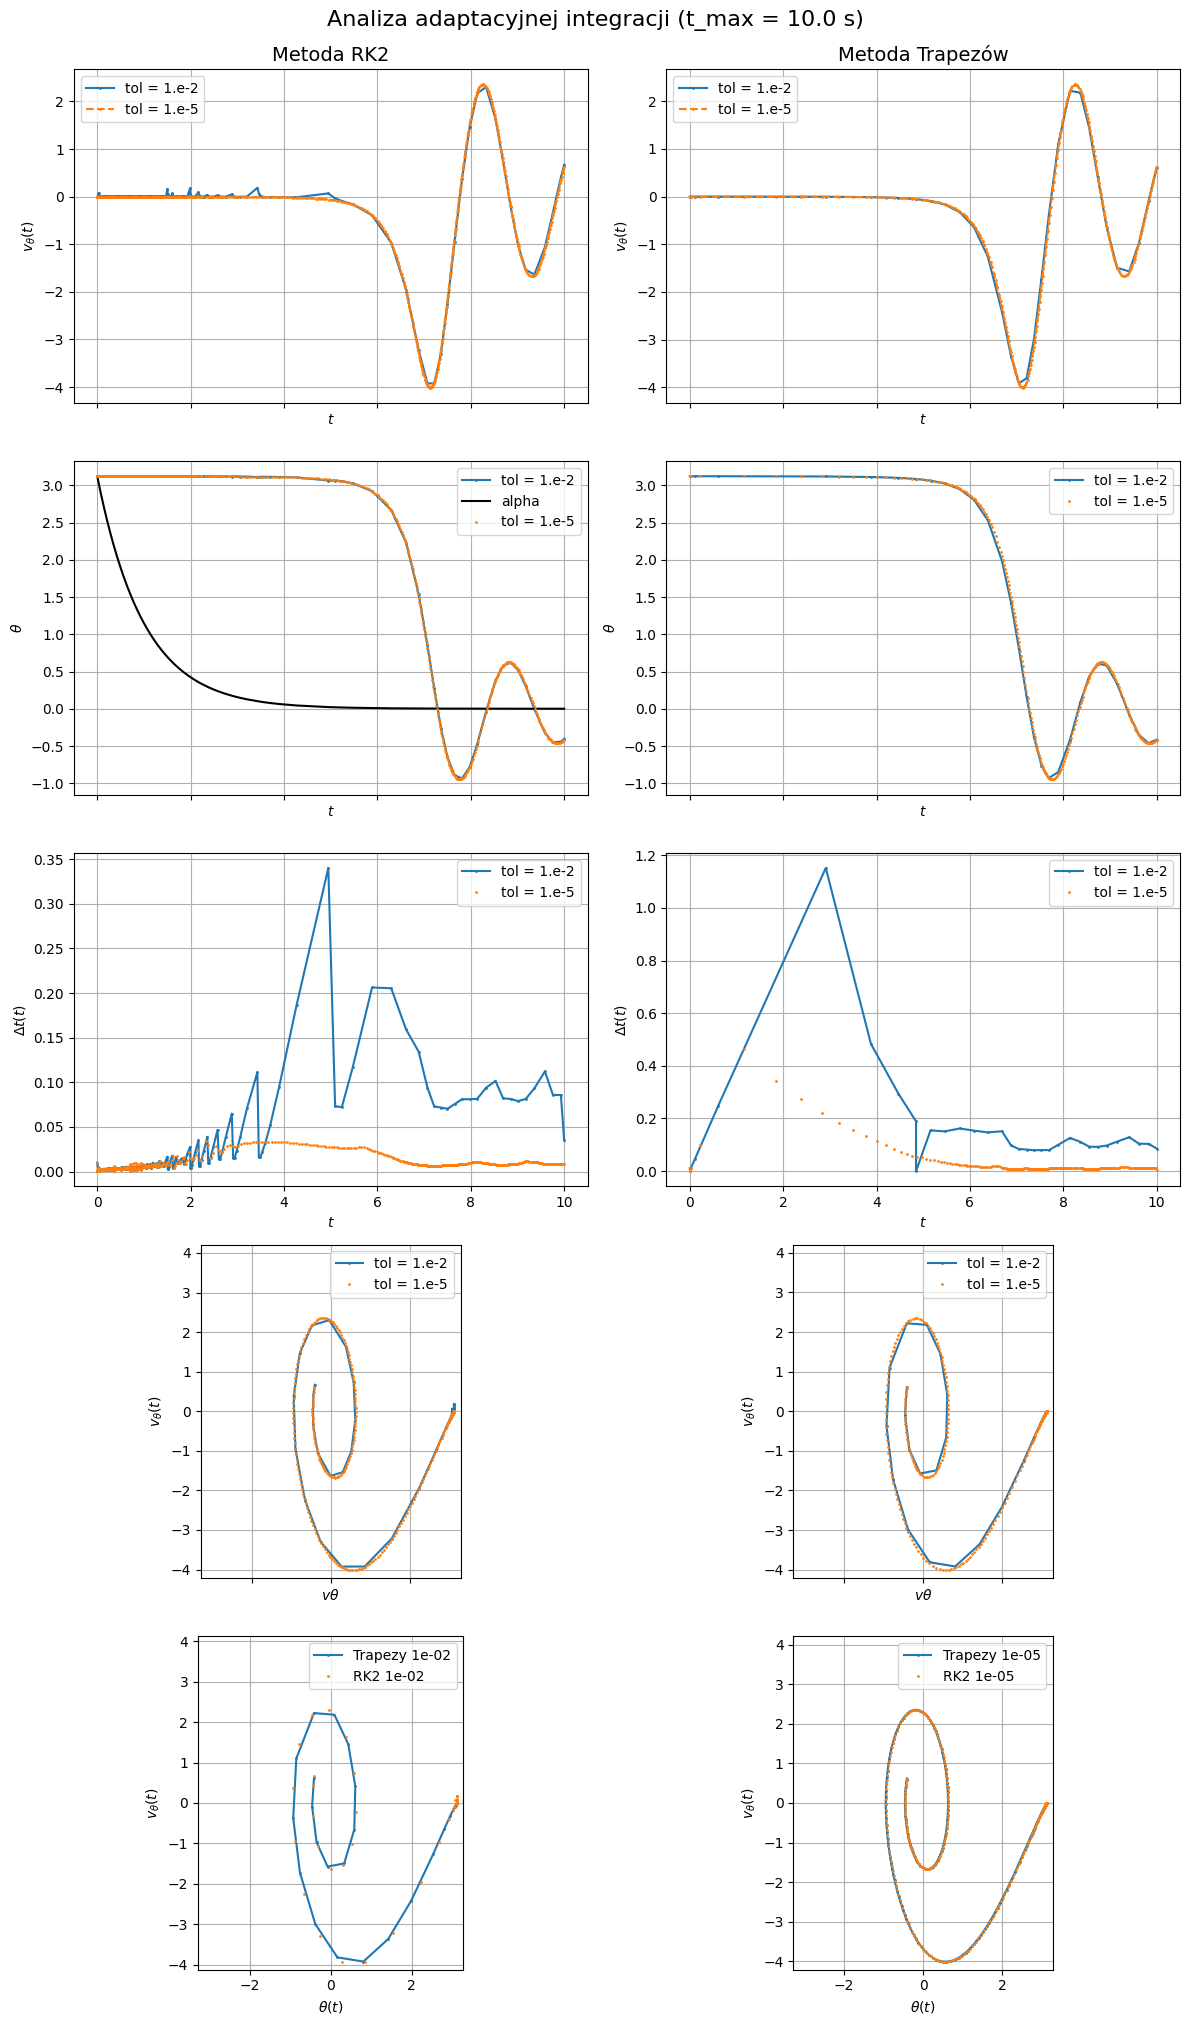

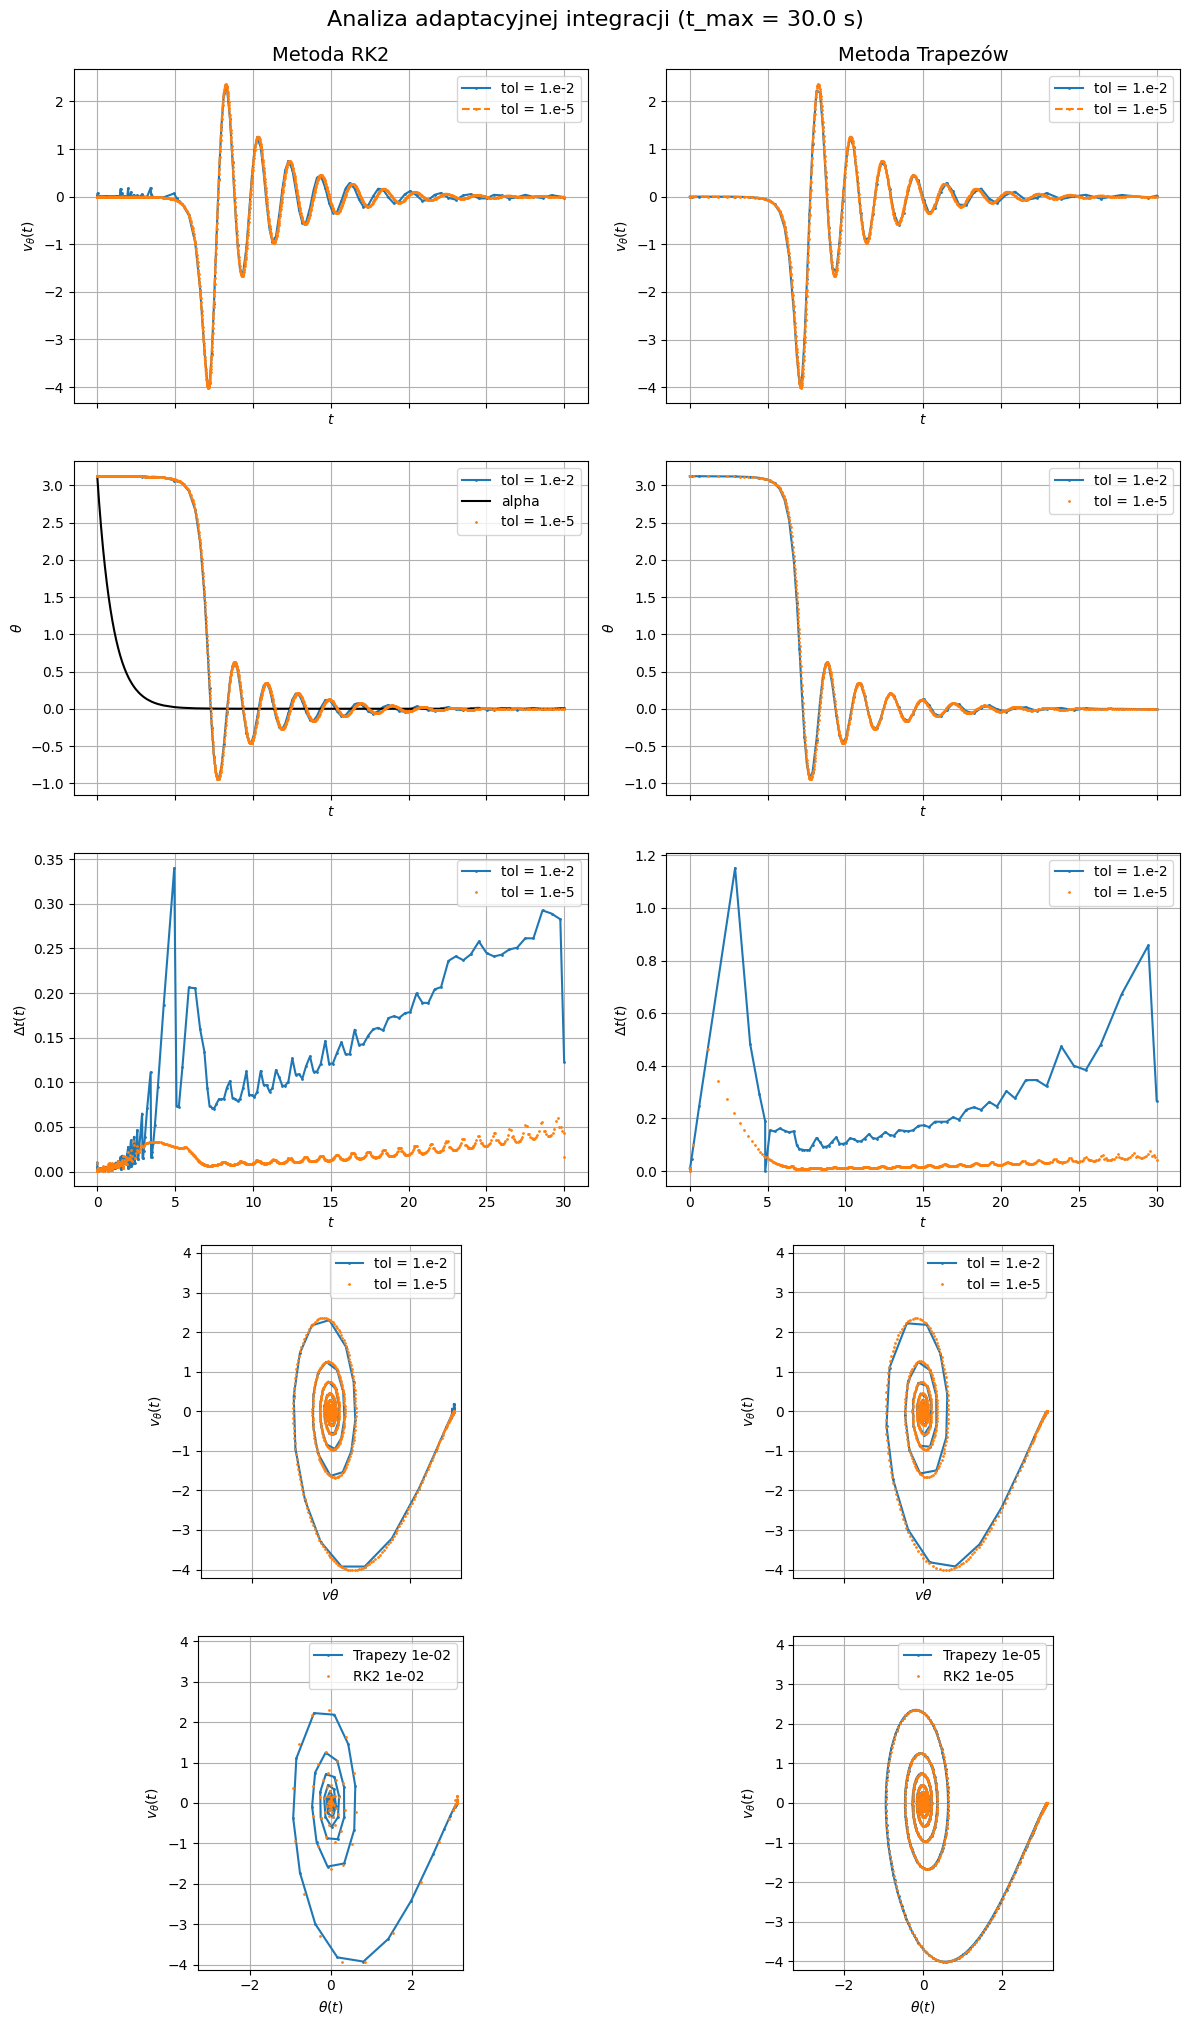

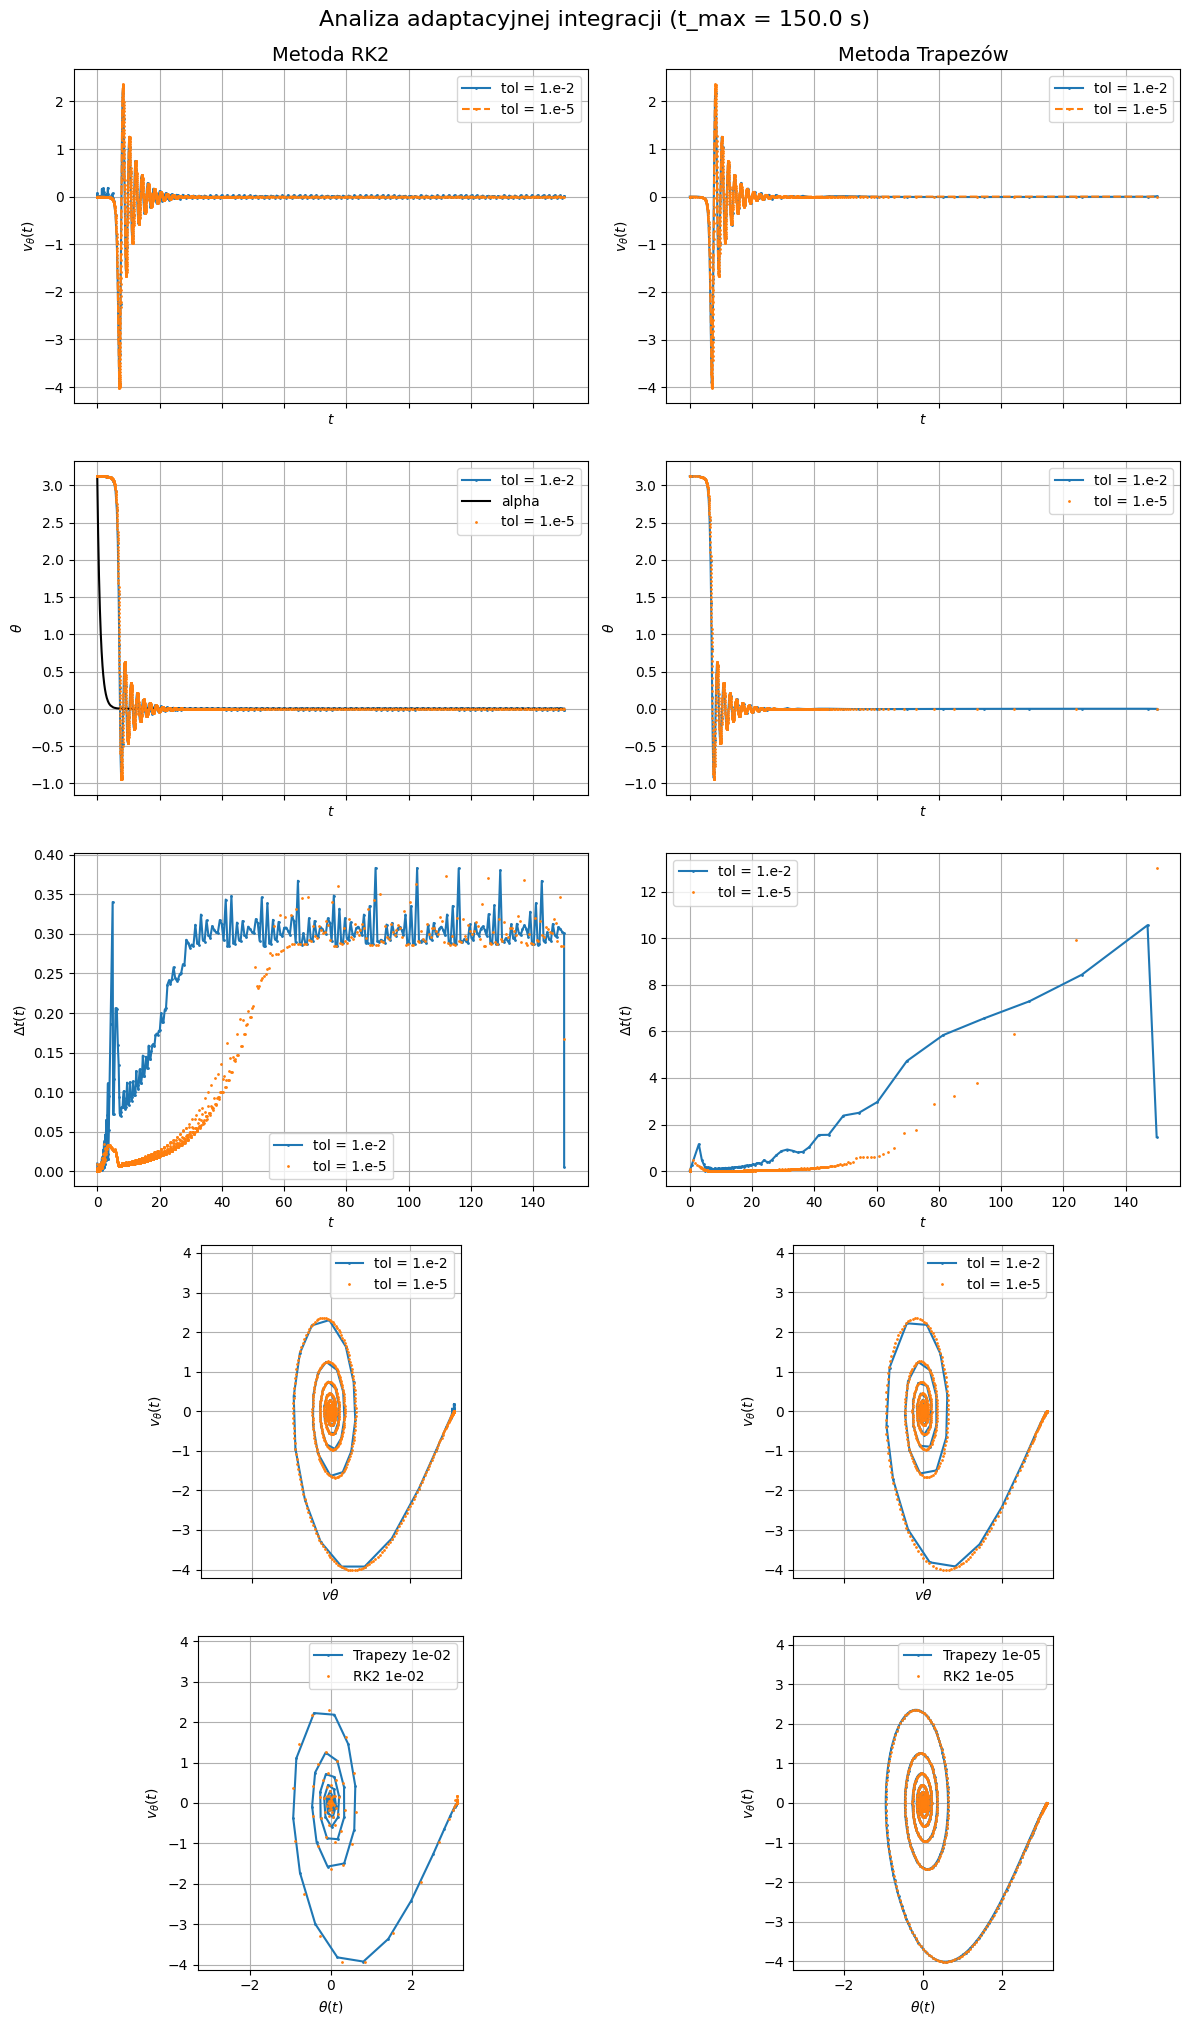

In [101]:
tmax_list = [10.0, 30.0, 150.0]

for tmax in tmax_list:
    fig = make_figure(tmax, results, alpha)
    fig.suptitle(f"Analiza adaptacyjnej integracji (t_max = {tmax:.1f} s)", fontsize=16, y=1.01)

    plt.show()
